Script to plot diagnostics of ROMY for a user-specified period

### Load Libraries

In [1]:
import matplotlib.pyplot as plt
import os, os.path

from datetime import datetime
from numpy import arange, array, cumsum
from pandas import read_csv, DataFrame
from numpy import zeros, median, linspace
from obspy import UTCDateTime
from numpy import isnan
from obspy import UTCDateTime

In [2]:
def __get_doy_from_date(doy, year):
    
    '''
    turn doy to date
    
    dependency: from dateime import datetime
    '''

    ## adjusting day num
    day_num = str(doy)
    day_num.rjust(3 + len(day_num), '0')
  
  
    ## converting to date
    res = datetime.strptime(str(year) + "-" + day_num, "%Y-%j").strftime("%Y-%m-%d")
  
    return str(res)

In [3]:
def __check_setup(paths):
    
    for path in paths: 
        if not os.path.exists(path):
            print(f"Error: directory {path} does not exists!")

In [4]:
def __merge_figures(figures):
    
    from PyPDF2 import PdfFileMerger, PdfFileReader
 
    ## Call the PdfFileMerger
    mergedObject = PdfFileMerger()

    ## Loop through all figures and append their pages
    for figure in figures:
        mergedObject.append(PdfFileReader(path2plots+figure+".pdf", 'rb'))

    ## Write all the files into a file which is named as shown below
    mergedObject.write(path2plots+"output"+".pdf")

### User Configurations

In [5]:
def __user_interaction():
    
    dbeg = input("\nEnter start date (e.g 2021-05-01): ")
    dend = input("Enter end date (default: equal startdate): ")
    
    if len(dend) == 0:
        dend=dbeg

    tbeg = input("\nEnter end time (e.g. 00:00): ")
    tend = input("Enter end time (default all day): ")
    
    if len(tend) == 0:
        tend = "23:59:59"

    beg = UTCDateTime(f"{dbeg} {tbeg}")
    end = UTCDateTime(f"{dend} {tend}")    
    
    
    return beg, end


beg, end = __user_interaction()

# beg = UTCDateTime("2019-10-01 00:00")
# end = UTCDateTime("2019-11-14 23:59:59")

##
workdir = f'/home/andbro/Documents/ROMY/QualityCheck'

cha = 'BJZ'

mode = 'runw'

## choose to save figures
save = True



Enter start date (e.g 2021-05-01): 2019-10-01
Enter end date (default: equal startdate): 2019-11-30

Enter end time (e.g. 00:00): 00:00
Enter end time (default all day): 


In [6]:
## which data to be loaded
year = beg.year

## path specifications
path2data = f'{workdir}/{mode}/logs/'
path2plots = f'{workdir}/{mode}/figs/'

__check_setup([workdir, path2data, path2plots])

## filename of input data
ifile = f'{year}_{cha}_overview'


figures = []

### Load Data

In [7]:
def __load_data(beg, end, path, ifile):

    '''
    Loading overview data for specified time period. 
    Sorting and checking for doubles. 
    '''
    
    if os.path.isfile(path2data+ifile):

        ## read data
        try:
            data = read_csv(path+ifile, delimiter=",")
        except:
            print(f"Error occurred while loading file: {path}{ifile}")


        ## sort data frame in case any mixup occured
        data = data.sort_values(by=['doy'], ascending=True, axis=0)


        ## check for doubles 
        doubles = 0
        if data.doy.duplicated().any():
            doubles +=1
        if doubles != 0:
            print(f"\n Break because {doubles} doubles were found!")
            sys.exit

        data_select = data[(data.doy >= beg.julday) & (data.doy <= end.julday)]
        
        return data_select
    
    else:
        if os.path.isdir(path2data):
            print(f"Error: file not found: {ifile}")
        else:
            print(f"Error: directory not found: {path2data}")

        
data = __load_data(beg, end, path2data, ifile)

### Calculations

In [8]:
## calculate shares
max_samples_per_day = max(data.total_samples)

q0p = data.Q0/max_samples_per_day*100
q1p = data.Q1/max_samples_per_day*100
q2p = data.Q2/max_samples_per_day*100

## calulate average and median
med = f'{round(data.frequency_med.median(),2)} Hz'
avg = f'{round(data.frequency_med.mean(),2)} +- {round(data.frequency_med.std(),3)} Hz'
print(f"median: {med} \naverage: {avg}")

## prepare month labels
# month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
# months = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30 ,31, 30]
# m_cum = cumsum(months)+1


median: 553.5 Hz 
average: 553.4 +- 0.125 Hz


### Plotting

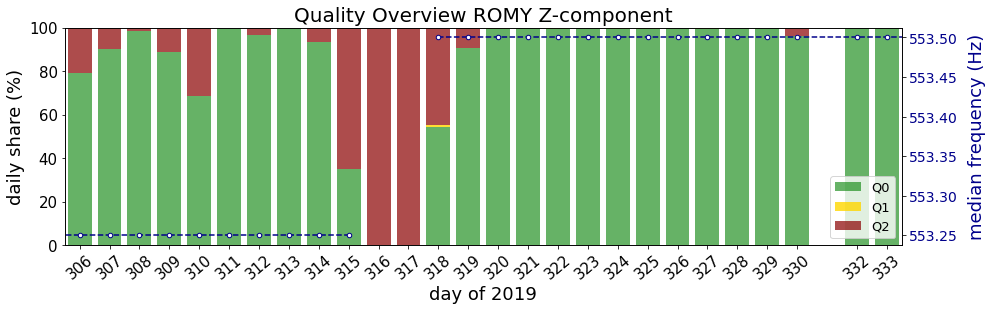


saving 2019_BJZ_overview_Nov2019_shares_frequency ...



In [21]:
def __makeplot_shares(cha, mode):

    fig, ax = plt.subplots(1, 1, figsize=(15,4))

    ## define font size
    font=16

    ## define x-bounds
    x1, x2 = array(data.doy)[0]+0.5, array(data.doy)[-1]-0.5


    width=0.8
    ax.bar(data.doy, q0p, width, color="green", alpha=0.6, label="Q0", edgecolor=None, aa=True)
    ax.bar(data.doy, q1p, width,bottom=q0p, color="gold", alpha=0.8, label="Q1", edgecolor=None, aa=True)
    ax.bar(data.doy, q2p, width,bottom=q0p+q1p, color="darkred", alpha=0.7, label="Q2", edgecolor=None, aa=True)

    ax.set_ylim(0,100)

    ax.set_xticks(data.doy)
    ax.set_xticklabels(data.doy, rotation=40)


#     ax.axhline(95, color='black', ls=':', label="95%")

    ax.set_ylabel("daily share (%)", fontsize=font+2)
    ax.set_xlabel(f"day of {year}", fontsize=font+2)

    ax.tick_params(axis='both', labelsize=font-1)

    ax.set_title(f"Quality Overview ROMY {cha[-1]}-component", fontsize=font+4)

    ax.legend(fontsize=font-3, loc="lower right")

    ax.set_xlim(x1,x2)


    ## add second access
    ax2 = ax.twinx()

    col2 = "darkblue"
    
    ax2.plot(data.doy, data.frequency_med, color=col2, ls='--', zorder=1)
    ax2.scatter(data.doy, data.frequency_med, color=col2, s=20, fc="white", label=r"f$_{median}$", zorder=2)


    ax2.tick_params(axis='both', labelsize=font-2, labelcolor=col2)
    ax2.set_ylabel("median frequency (Hz)", fontsize=font+2, color=col2, labelpad=10)

#     if cha == "BJZ":
#         ax2.set_ylim(553.2, 553.6)
#     if cha == "BJU":
#         ax2.set_ylim(302.5, 303.0)
#     if cha == "BJV":
#         ax2.set_ylim(447.7, 447.8)

    plt.show();
    
    return fig


## _____________________________________

fig = __makeplot_shares(cha, mode)


if save:
    figname = f"{year}_{cha}_overview_Nov2019_shares_frequency"
    print(f"\nsaving {figname} ...\n")
    fig.savefig(path2plots+figname+".pdf", format="pdf", dpi=300)
    figures.append(figname)

skipped 2019-10-01
skipped 2019-10-02
skipped 2019-10-03
skipped 2019-10-04
skipped 2019-10-05
skipped 2019-10-06
skipped 2019-10-07
skipped 2019-10-08
skipped 2019-10-09
skipped 2019-10-10
skipped 2019-10-11
skipped 2019-10-12
skipped 2019-10-13
skipped 2019-10-14
skipped 2019-10-15
skipped 2019-10-16
skipped 2019-10-17
skipped 2019-10-18
skipped 2019-10-19
skipped 2019-10-20
skipped 2019-10-21
skipped 2019-10-22
skipped 2019-10-23
skipped 2019-10-24
skipped 2019-10-25
skipped 2019-10-26
skipped 2019-10-27
skipped 2019-10-28
skipped 2019-10-29
skipped 2019-10-30
skipped 2019-10-31
skipped 2019-11-27

saving 2019_BJZ_overview_Nov2019_times ...



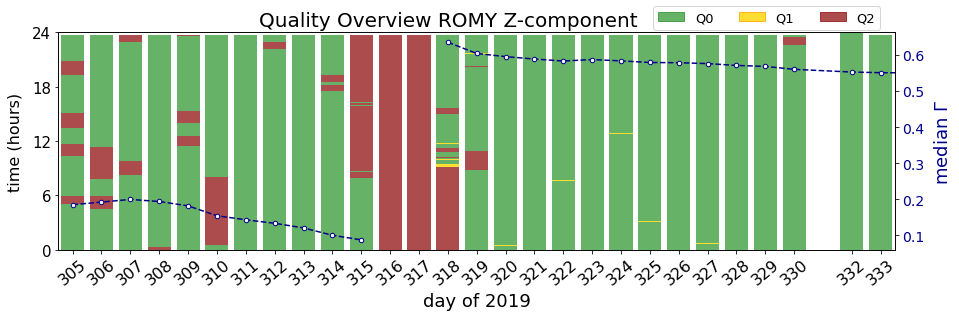

In [10]:
def __makeplot_times(cha, mode):

    if mode == "runy":
        hsw = 30
    elif mode == "runx":
        hsw = 90
    elif mode == "runz":
        hsw = 1        
    elif mode == "runq":
        hsw = 1     
    elif mode == "runw":
        hsw = 1          

    
    ## _______________________________________
    ##
    
    fig, ax = plt.subplots(1,1, figsize=(15,4))

    ## define fontsize
    font = 16

    daylabels, dayticks = [], []
    
    if beg.julday == end.julday:
        doy1, doy2 = beg.julday, beg.julday+1
    else:
        doy1, doy2 = beg.julday, end.julday

    j, not_first = 0, False
    for doy in range(doy1, doy2):

        date = UTCDateTime(__get_doy_from_date(doy, beg.year))

        mm = str(date.month).rjust(2, "0")
        dd = str(date.day).rjust(2, "0")
        
        path2cfiles = f"{workdir}/{mode}/Cfiles/{date.year}-{mm}/{date.year}-{mm}-{dd}.C{cha[-1]}"


        try:

            ## read daily C-file
            df = read_csv(path2cfiles)


            ## divide into bars of quality
            bars = []
            for l in range(df.seconds.size):
                if l>0: 
                    bars.append(df.seconds[l] - df.seconds[l-1])

            qual = df.quality[:-1]  

            ## color dictionary
            col_dict = {0:'green',1:'gold', 2:'darkred'}
            alphas   = {0:0.6,1:0.8,2:0.7}

            ## plotting of bars
            for i, val in enumerate(bars):

                ax.bar(doy, 
                       val, bottom=sum(bars[:i]), 
                       color=col_dict[qual[i]], 
                       alpha=alphas[qual[i]],
                      )
            
            daylabels.append(str(f"{doy}"))
            dayticks.append(int(doy))            
            
            j += 1
            boolean = True
            del df
        
        except:
            print(f"skipped {year}-{mm}-{dd}")
            
            ## plot white bar if not first bar overall to fill gaps
            if not_first == True:
                ax.bar(doy, 86400, color="white")
                
                daylabels.append(str(f"{doy}"))
                dayticks.append(int(doy))  
                
        
        ## tweak x axis    
        ax.set_xticks(dayticks)   
        ax.set_xticklabels(daylabels, fontsize=font, rotation=40)
        ax.set_xlabel(f"day of {year}", fontsize=font+2)

        ## tweak y axis
        ax.set_yticks(linspace(0,86400,5))
        ax.set_yticklabels(linspace(0,24,5, dtype=int), fontsize=font-1)
        ax.set_ylim(0, 86400)
        ax.set_ylabel('time (hours)', fontsize=font, labelpad=10)

        ax.set_title(f"Quality Overview ROMY.{cha} {year}            ", fontsize=font+4)
        ax.set_title(f"Quality Overview ROMY {cha[-1]}-component         ", fontsize=font+4)


        from matplotlib.patches import Polygon, Patch
        legend_elements = [Patch(facecolor='green'    , edgecolor='green', label='Q0', alpha=0.6),
                           Patch(facecolor='gold'    , edgecolor='orange', label='Q1', alpha=0.8),
                           Patch(facecolor='darkred', edgecolor='darkred', label='Q2', alpha=0.7),
                          ]        

        ax.legend(handles=legend_elements, fontsize=font-3, ncol=3, loc="upper right", bbox_to_anchor=[0.99, 1.15])      



    
    ## add second access
    ax2 = ax.twinx()

    col2 = "darkblue"
    
    ax2.plot(data.doy, data.contrast, color=col2, ls='--', zorder=3)
    ax2.scatter(data.doy, data.contrast, color=col2, s=20, fc="white", label=r"$\Gamma_{median}$", zorder=4)

    ax2.tick_params(axis='both', labelsize=font-2, labelcolor=col2)
    ax2.set_ylabel(r"median $\Gamma$", fontsize=font+2, color=col2, labelpad=10)
    
    
    ax.set_xlim(dayticks[0]-0.5, dayticks[-1]+0.5)
    ax.set_ylim(0, 86400)
    
    
    return fig

        
## _____________________________________

fig = __makeplot_times(cha, mode)


if save:
    figname = f"{year}_{cha}_overview_Nov2019_times"
    print(f"\nsaving {figname} ...\n")
    fig.savefig(path2plots+ figname+".pdf", format="pdf", dpi=300)
    figures.append(figname)


### Merge Figures

In [11]:
__merge_figures(figures)